In [10]:
from Models import mobilenetv2
import torch
import torch.optim as optim
import torch.nn as nn
from Dataloaders import dataloader_cifar10
from tqdm import tqdm

accuracy = []
_, test, _ = dataloader_cifar10.Dataloader_cifar10_val(train_batch=128, test_batch=100, seed=2024)
for i in range(1,9):
    model = mobilenetv2.MobileNetV2_together_n(num_classes=10, middle=i)
    model.load_state_dict(torch.load('model_together_' + str(i) +'.pth'))
    device = torch.device('cuda:0')
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        all_correct = 0
        for i, data in enumerate(test):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            outputs = torch.argmax(outputs, dim=1)
            correct = torch.sum(outputs == labels)
            all_correct += correct
        accuracy.append(all_correct.item()/10000)


Files already downloaded and verified
Files already downloaded and verified


/home/tonypeng/anaconda3/envs/iot/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


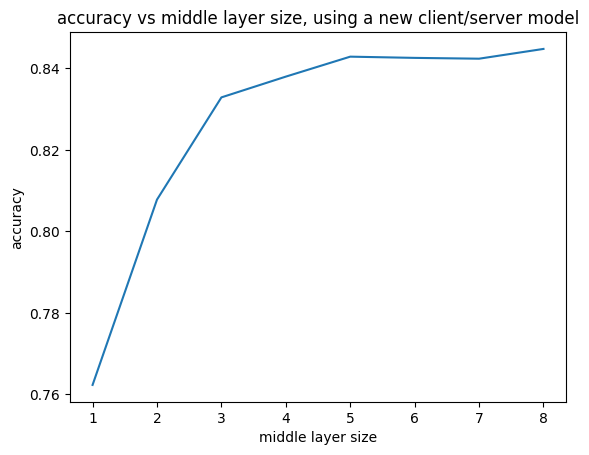

In [11]:
# plot acc vs middle layer size
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(1,9)
plt.plot(x, accuracy)
plt.xlabel('middle layer size')
plt.ylabel('accuracy')
plt.title('accuracy vs middle layer size, using a new client/server model')
plt.show()

Files already downloaded and verified
Files already downloaded and verified


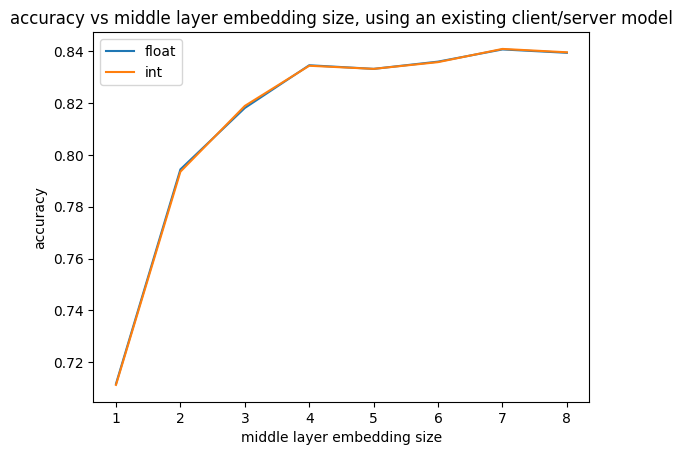

In [12]:
from Models import mobilenetv2
import torch
import torch.optim as optim
import torch.nn as nn
from Dataloaders import dataloader_cifar10
from tqdm import tqdm
import seaborn as sns

middle_accuracy = []
_, test, _ = dataloader_cifar10.Dataloader_cifar10_val(train_batch=128, test_batch=100, seed=2024)

client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10,
                                                  weight_root='/home/tonypeng/Workspace1/adaptfilter/Adaptfilter/Weights/cifar-10',
                                                  device='cuda:0',partition=-1)

device = torch.device('cuda:0')
client = client.to(device)
server = server.to(device)
client = client.eval()
server = server.eval()



for i in range(1,9):
    middle_size = i
    middle = mobilenetv2.MobileNetV2_middle(middle=middle_size)
    middle.load_state_dict(torch.load('model_middle_' + str(middle_size) +'.pth'))
    middle = middle.to(device)
    middle = middle.eval()
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(test):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = client(inputs)
            outputs = middle(outputs)
            outputs = server(outputs)
            outputs = torch.argmax(outputs, dim=1)
            correct += torch.sum(outputs == labels)
        middle_accuracy.append(correct.item()/10000)

# plot acc vs middle layer size
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(1,9)
plt.plot(x, middle_accuracy, label='float')
plt.xlabel('middle layer embedding size')
plt.ylabel('accuracy')
plt.title('accuracy vs middle layer embedding size, using an existing client/server model')

middle_accuracy_int = []
for i in range(1,9):
    middle_size = i
    middle = mobilenetv2.MobileNetV2_middle(middle=middle_size)
    middle.load_state_dict(torch.load('model_middle_' + str(middle_size) +'.pth'))
    middle = middle.to(device)
    middle = middle.eval()
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(test):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = client(inputs)
            outputs = middle.in_layer(outputs)

            # float to int 
            outputs = outputs * 255
            outputs = outputs.int()
            outputs = outputs.float()
            outputs = outputs / 255

            outputs = middle.out_layer(outputs)

            outputs = server(outputs)
            outputs = torch.argmax(outputs, dim=1)
            correct += torch.sum(outputs == labels)
        middle_accuracy_int.append(correct.item()/10000)

plt.plot(x, middle_accuracy_int, label='int')
plt.legend()
plt.show()

Files already downloaded and verified
Files already downloaded and verified


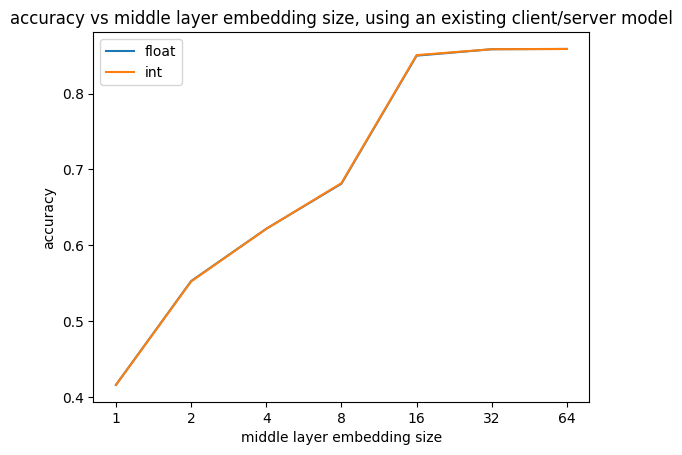

In [13]:
from Models import mobilenetv2, resnet
import torch
import torch.optim as optim
import torch.nn as nn
from Dataloaders import dataloader_cifar10
from tqdm import tqdm

middle_accuracy = []
_, test, _ = dataloader_cifar10.Dataloader_cifar10_val(train_batch=128, test_batch=100, seed=2024)

client, server = resnet.resnet_splitter(num_classes=10,
                                                  weight_root='/home/tonypeng/Workspace1/adaptfilter/Adaptfilter/Weights/cifar-10',
                                                  device='cuda:0',partition=-1,
                                                  layers=50)

device = torch.device('cuda:0')
client = client.to(device)
server = server.to(device)
client = client.eval()
server = server.eval()



for i in range(0,7):
    middle_size = i
    middle = resnet.resnet_middle(middle=2**middle_size)
    middle = middle.to(device)
    middle = middle.eval()
    middle.load_state_dict(torch.load('resnet_cifar-10_middle_' + str(2**middle_size) +'.pth'))
    
    
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(test):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = client(inputs)
            outputs = middle(outputs)
            outputs = server(outputs)
            outputs = torch.argmax(outputs, dim=1)
            correct += torch.sum(outputs == labels)
        middle_accuracy.append(correct.item()/10000)

# plot acc vs middle layer size
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(0,7)
plt.plot(x, middle_accuracy, label='float')
plt.xlabel('middle layer embedding size')
plt.ylabel('accuracy')
plt.xticks(x, [str(2**i) for i in x])
plt.title('accuracy vs middle layer embedding size, using an existing client/server model')

middle_accuracy_int = []
for i in range(0,7):
    middle_size = i
    middle = resnet.resnet_middle(middle=2**middle_size)
    middle = middle.to(device)
    middle = middle.eval()
    middle.load_state_dict(torch.load('resnet_cifar-10_middle_' + str(2**middle_size) +'.pth'))
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(test):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = client(inputs)
            outputs = middle.in_layer(outputs)

            # float to int 
            outputs = outputs * 255
            outputs = outputs.int()
            outputs = outputs.float()
            outputs = outputs / 255

            outputs = middle.out_layer(outputs)

            outputs = server(outputs)
            outputs = torch.argmax(outputs, dim=1)
            correct += torch.sum(outputs == labels)
        middle_accuracy_int.append(correct.item()/10000)

plt.plot(x, middle_accuracy_int, label='int')
plt.legend()
plt.show()